In [1]:
%%html
<style>
table { font-variant-numeric: tabular-nums; }
</style>

In [11]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymysql

plt.rcParams['svg.fonttype'] = 'path'

sns.set(font_scale=1.25)
sns.set_style("white", {"font.sans-serif": ["AU Passata"]})

In [12]:
con = pymysql.connect(host='localhost', user='frontend', password='XXX', db='genomedk', charset='utf8', cursorclass=pymysql.cursors.DictCursor)

In [13]:
def create_order(x=None, y=None, data=None, limit=None, order=None, estimator=None, **kwargs):
    if limit is not None and order is not None:
        raise ValueError('order must not be set when using limit')
    
    if limit is not None:
        if isinstance(limit, tuple):
            limit_to, ascending = limit
        else:
            limit_to, ascending = limit, False
            
        order = (
            data.pivot_table(index=y, values=x, aggfunc=estimator)
                .sort_values(by=x, ascending=ascending)
        )
        if limit is not None:
            order = order.head(limit_to).index
    return order


def barplot(**kwargs):
    order = create_order(**kwargs)
    kwargs.pop('limit')
    return sns.barplot(**kwargs, order=order)

barplot.__doc__ = sns.barplot.__doc__

# Users

In [14]:
active_users = pd.read_sql_query(sql='select uid, organization from users where username <> "root" and state = "active"', con=con)

In [15]:
len(active_users)

531

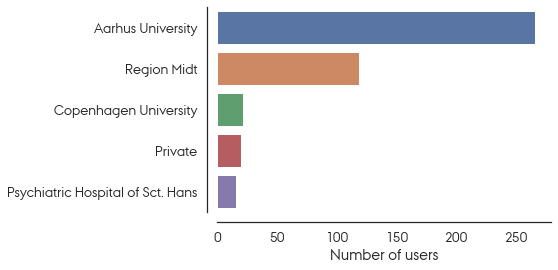

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (8, 4))
sns.countplot(y='organization', data=active_users, order=active_users.organization.value_counts().head(5).index)
sns.despine(offset=10)
ax.set_ylabel('')
ax.set_xlabel("Number of users")
sns.despine(offset=10)
plt.tight_layout()
plt.savefig('top5_users.svg', format='svg', transparent=True, bbox_inches='tight')

# Compute

In [19]:
billing_hours = pd.read_sql_query(sql='select * from billing_hours', con=con, parse_dates=['timestamp'])
billing_hours = billing_hours.set_index('timestamp')
billing_hours = billing_hours['2019-06-01':'2020-06-01']

In [20]:
billing_hours['mio_billing_hours'] = billing_hours.billing_hours / 1e6
billing_hours['mio_num_jobs'] = billing_hours.num_jobs / 1e6

Cost of all billing hours used in the period, in millions:

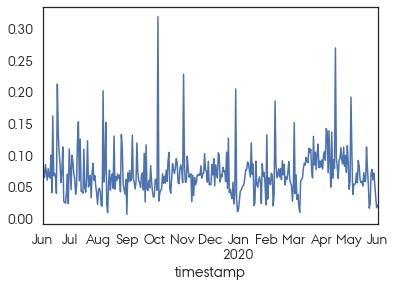

In [50]:
billing_hours.mio_billing_hours.resample('1D').sum().plot()

Number of jobs started in the period, in millions:

In [25]:
billing_hours.mio_num_jobs.sum()

14.434868

Busiest day:

In [47]:
billing_hours.mio_num_jobs.resample('1D').sum().idxmax()

Timestamp('2020-04-30 00:00:00', freq='D')

In [48]:
int(round(billing_hours.mio_num_jobs.resample('1D').sum().max() * 1e6))

855489

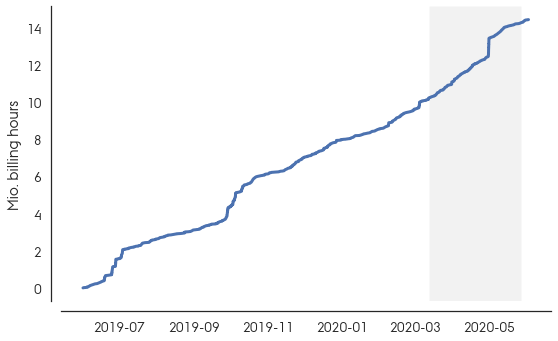

In [104]:
from datetime import date
from matplotlib.dates import date2num

corona_start = date(2020, 3, 12)
corona_end = date(2020, 5, 27)

plt.figure(figsize=(8, 5))
ax = billing_hours.mio_num_jobs.cumsum().plot(lw=3)
ax.axvspan(corona_start, corona_end, facecolor='black', alpha=0.05)

ax.set_xlabel("")
ax.set_ylabel("Mio. billing hours")

sns.despine(offset=10)
plt.tight_layout()
plt.savefig('cumulative_billing_hours.svg', format='svg', transparent=True, bbox_inches='tight')

## Top five organizations

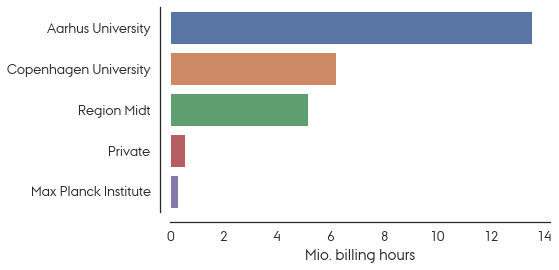

In [40]:
billing_hours_per_org = pd.merge(
    left=billing_hours,
    right=active_users,
    on='uid'
).pivot_table(
    index='organization',
    values='mio_billing_hours',
    aggfunc='sum'
).sort_values(
    'mio_billing_hours',
    ascending=False
).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.barplot(
    y='organization', 
    x='mio_billing_hours',
    data=billing_hours_per_org,
    ci=None,
    estimator=np.sum,
    order=billing_hours_per_org.groupby('organization').mio_billing_hours.sum().sort_values(ascending=False).iloc[:5].index,
    ax=ax,
)

ax.set_ylabel('')
ax.set_xlabel("Mio. billing hours")
sns.despine(offset=10)
plt.tight_layout()
plt.savefig('top5_organizations.svg', format='svg', transparent=True, bbox_inches='tight')

## Activity map

In [41]:
weekday_cat = pd.CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

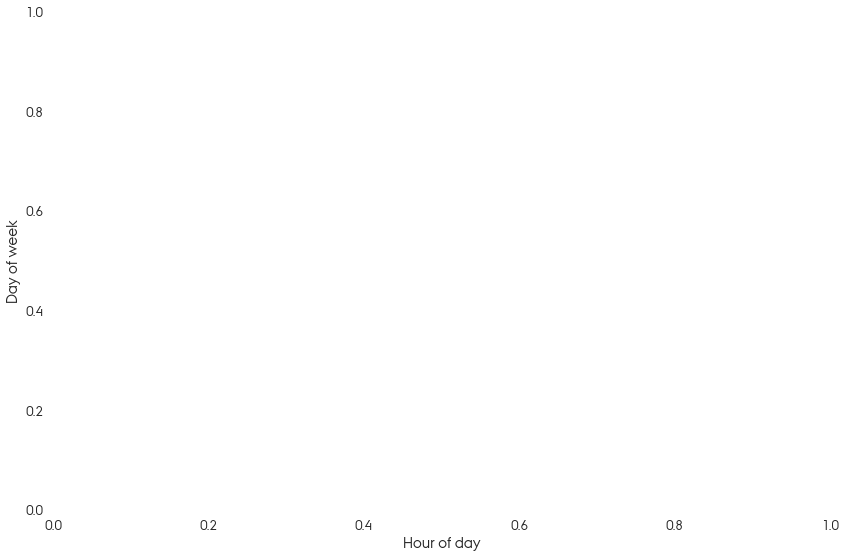

In [45]:
fig, ax = plt.subplots(1, 1, figsize = (12, 8))

billing_hours.assign(
    dayofweek=billing_hours.index.weekday.astype(weekday_cat),
    hour=billing_hours.index.hour,
).pivot_table(
    index='dayofweek',
    columns='hour',
    values='mio_num_jobs',
    aggfunc='sum',
)

#.pipe(
#    sns.heatmap,
#    cbar=False,
#    square=True,
#    cmap=sns.cubehelix_palette(light=1, as_cmap=True),
#)

ax.set_ylabel('Day of week')
ax.set_xlabel('Hour of day')
sns.despine(offset=10, left=True, bottom=True)
plt.tight_layout()
# plt.savefig('activity_week.svg', format='svg', transparent=True, bbox_inches='tight')

# Storage

In [46]:
projects = pd.read_sql_query(sql='select * from projects', con=con)

In [47]:
stor_proj = pd.read_sql_query(sql='select * from storage_project', con=con, parse_dates=['timestamp'])
stor_proj = stor_proj.set_index('timestamp')

In [48]:
stor_proj = stor_proj['2019-06-08']
stor_proj['num_files'] = stor_proj['backup_bytes']

Largest projects by number of files, in millions:

In [54]:
stor_proj.merge(
    projects, on='gid'
).pivot_table(
    index='name',
    values=['num_files'],
    aggfunc='sum'
).sort_values(
    'num_files', ascending=False
).head(10) / 1e6

,num_files
name,
IGdata,68.092513
MammalianMutation,21.433107
MomaRAWfiles,21.044522
norfab,13.345776
NChain,13.205542
MomaDiagnostics,12.085268
MolGen,10.145219
spider2,8.145851
DanishPanGenome2,8.036533


Largest projects by size, in terabytes:

In [56]:
stor_proj.merge(
    projects, on='gid'
).pivot_table(
    index='name',
    values=['usage_bytes'],
    aggfunc='sum'
).sort_values(
    'usage_bytes', ascending=False
).head(10) / 1e12

,usage_bytes
name,
DBS_Exomes,370.939389
DanishPanGenome2,329.343493
MammalianMutation,302.308475
RetroVirus,245.870299
MolGen,190.988718
iPSYCH_BAM,190.045887
ExomeSeqClinical,154.101864
IGdata,146.507772
CUP_classification,114.080331


Now compute the total storage usage per organization and sum it up in a nice plot...

In [58]:
stor_home = pd.read_sql_query(sql='select * from storage_home', con=con)
stor_home = stor_home.set_index('timestamp')

In [61]:
stor_home_per_user = stor_home['2019-06-08']

# Switch around backup_bytes and num_files because of insertion mistake in database...
stor_home_per_user['num_files'] = stor_home_per_user['backup_bytes']
stor_home_per_user = stor_home_per_user.groupby(['timestamp', 'uid']).usage_bytes.sum().reset_index()

/Users/das/.pyenv/versions/miniconda3-latest/envs/genomedk-newsletter-summer-2019/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [62]:
stor_proj_per_user = stor_proj['2019-06-08']
# Switch around backup_bytes and num_files because of insertion mistake in database...
stor_proj_per_user['num_files'] = stor_proj_per_user['backup_bytes']
stor_proj_per_user = stor_proj_per_user.groupby(['timestamp', 'uid']).usage_bytes.sum().reset_index()

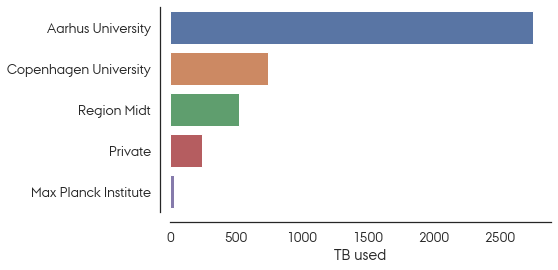

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

usage_per_organization = (
    pd.concat([stor_proj_per_user, stor_home_per_user])
      .groupby('uid')
      .sum()
      .merge(users, on='uid')
      .assign(usage_tb=lambda df: df['usage_bytes'] / 1e12)
      .pipe((barplot, 'data'), y='organization', x='usage_tb', ci=None, estimator=np.sum, ax=ax, limit=5)
)

ax.set_ylabel('')
ax.set_xlabel('TB used')
sns.despine(offset=10)
plt.tight_layout()
plt.savefig('top5_organizations_storage.svg', format='svg', transparent=True, bbox_inches='tight')